In [1]:
%pylab inline

from PyTools import err, binner, nbins
from sklearn.cluster import DBSCAN
from string import join
import pyfits as pyf
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="serif", serif="Times New Roman", weight="bold", size=9.0)
rc("text", usetex=True)
rc("savefig", dpi=92)
rc("axes", linewidth=0.5, labelsize=9.0, titlesize=9.0)
rc("legend", fontsize="xx-small")
rc("xtick.major", width=0.3)
rc("xtick", labelsize="small")
rc("ytick.major", width=0.3)
rc("ytick", labelsize="small")

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]
res_lbs = [r"$\Delta_r M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
           r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$",
           r"$\Delta A_V$"]

od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")

In [3]:
#READ TABLES

catalog = genfromtxt("catalog.txt", dtype=None, names=True)
spec_ne = genfromtxt("spec_ne.txt", dtype=None, names=True)
jpas_ye = genfromtxt("jpas_ye.txt", dtype=None, names=True)
jpas_ne = genfromtxt("jpas_ne.txt", dtype=None, names=True)
jpas_me = genfromtxt("jpas_me.txt", dtype=None, names=True)
gal2005 = genfromtxt("gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])
lumfrac = genfromtxt("lumfrac.txt", dtype=None, names=True)

SN = []
for fits in catalog["input_file"]:
    f = pyf.open("../inputs/real_deal6/unfiltered/"+fits)
    SN.append(median(f[0].data[0]/f[0].data[2]))
SN = array(SN)

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide


In [4]:
#COMMON QUANTITIES

lcolor = catalog["u_mag"] - catalog["r_mag"]
rfract = 10**(-0.4*(lumfrac["modelMag_r"]-lumfrac["fiberMag_r"]))

bmask = lcolor < 2.22
rmask = ~bmask
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
gmask = array([n in gal2005["input_file"] for n in catalog["input_file"]], dtype=bool)

kw = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
rl = [False]*6
lb = [r"$\Delta \log{M_\star/M\odot}$", r"$\Delta\left<\log{t_\star}\right>_M$",
      r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$", r"$\Delta A_V$"]

In [5]:
zmask = (spec_ne[gmask]["log_Z_L_mod"]>log10(0.004/0.02))&(gal2005["z_mode"]>log10(0.004/0.02))
sfgal = lcolor[gmask][zmask]<2.22
pagal = lcolor[gmask][zmask]>2.22

s = spec_ne[gmask][zmask]
g = gal2005[zmask]

X = zeros((s.size, 2))
X[:, 0], X[:, 1] = s["log_t_L_mod"], s["log_Z_L_mod"]

print "tables match? ", all(g["input_file"]==s["input_file"])

tables match?  True


In [6]:
db = DBSCAN(eps=0.03, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

labels[labels==2] = 1
labels[labels==3] = 0
labels[labels==4] = -1
labels[labels==5] = 1
labels[labels==6] = 1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
c1m = labels==0
c2m = labels==1

<Container object of 3 artists>

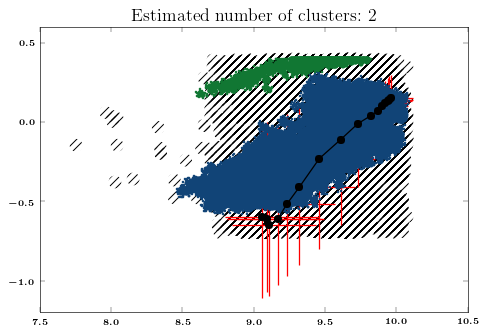

In [22]:
scatter(g["t_mode"], g["z_mode"], c="none", s=100, lw=0, hatch="///")

#############################################################################################
#colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
colors = ["#114477", "#117733"]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        continue

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', mfc=col, mec='none', markersize=4, label="cluster #{0}".format(k+1))

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', mfc=col, mec='none', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_, size=14)
#legend(loc=0, frameon=False, numpoints=1, fontsize=12)
#############################################################################################
#plot(s["log_t_L_mod"][pagal], s["log_Z_L_mod"][pagal], ".", mew=0, mfc="red")
#plot(s["log_t_L_mod"][sfgal], s["log_Z_L_mod"][sfgal], ".", mew=0, mfc="maroon")
#plot(g["t_mode"][c2m], g["z_mode"][c2m], "x", color="maroon")
errorbar(galtab2[:, 4], galtab2[:, 1], xerr=[abs(galtab2[:, 4]-galtab2[:, 5]), abs(galtab2[:, 4]-galtab2[:, 6])],
        yerr=[abs(galtab2[:, 1]-galtab2[:, 2]), abs(galtab2[:, 1]-galtab2[:, 3])], fmt="-ok", ecolor="r", barsabove=True)

#xlabel("Age (log/yr)")
#ylabel("Z (log/Z$\odot$)")
#savefig("age_met.png", bbox_inches="tight")

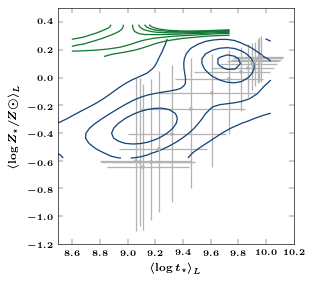

In [23]:
fig = figure(figsize=(3.3, 3.3))
xlim(8.5, 10.2)
ylim(-1.2, 0.5)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

errorbar(galtab2[:, 4], galtab2[:, 1], xerr=[abs(galtab2[:, 4]-galtab2[:, 5]), abs(galtab2[:, 4]-galtab2[:, 6])],
        yerr=[abs(galtab2[:, 1]-galtab2[:, 2]), abs(galtab2[:, 1]-galtab2[:, 3])], fmt="o", color="0.7",
         ecolor="0.7", ms=3)

#CONTOURS FOR CLUSTER #1
nx, xi, xf, bsx = nbins(X[c1m, 0])
ny, yi, yf, bsy = nbins(X[c1m, 1])

H, xe, ye = histogram2d(X[c1m, 0], X[c1m, 1], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0], levels=np.arange(0.2, 10, 0.7))

#CONTOURS FOR CLUSTER #2
nx, xi, xf, bsx = nbins(X[c2m, 0])
ny, yi, yf, bsy = nbins(X[c2m, 1])

H, xe, ye = histogram2d(X[c2m, 0], X[c2m, 1], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[1], levels=np.arange(1.5, 10, 1.5))

savefig(od + "age_met.pdf", bbox_inches="tight")

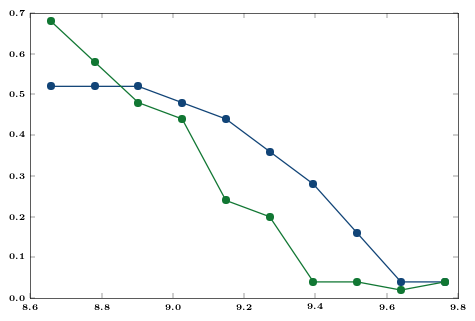

In [31]:
x, y = binner(s["log_t_L_mod"][c1m], s["Av_mod"][c1m], "median", 10, [min(s["log_t_L_mod"][c2m]), max(s["log_t_L_mod"][c2m])])
plot(x, y, "o-", ms=7, mew=0, color=colors[0])

x, y = binner(s["log_t_L_mod"][c2m], s["Av_mod"][c2m], "median", 10, [min(s["log_t_L_mod"][c2m]), max(s["log_t_L_mod"][c2m])])
plot(x, y, "o-", ms=7, mew=0, color=colors[1])

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  from ipykernel import kernelapp as app
/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  app.launch_new_instance()
/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347


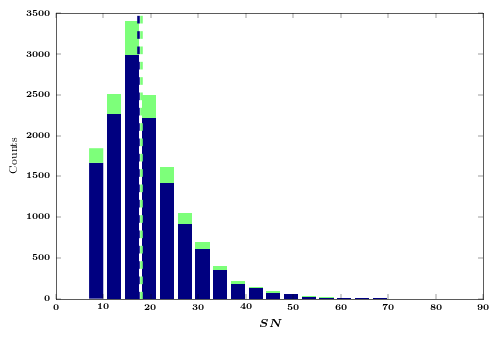

In [16]:
hist([SN[gmask][c1m], SN[gmask][c2m]], 20, histtype="barstacked", lw=0, color=[colors[0], colors[1]])
axvline(median(SN[gmask][c1m]), ls="--", color=colors[0], lw=2)
axvline(median(SN[gmask][c2m]), ls="--", color=colors[1], lw=2)
xlabel("$SN$")
ylabel("Counts")

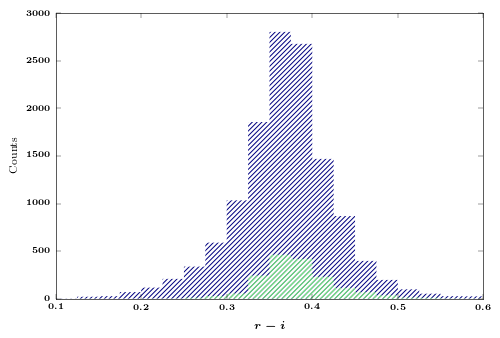

In [10]:
cat = catalog[gmask][zmask]

hist((cat["r_mag"]-cat["i_mag"])[c1m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[0])
hist((cat["r_mag"]-cat["i_mag"])[c2m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[1])
xlabel("$r-i$")
ylabel("Counts")
#savefig("r-i.png", bbox_inches="tight")

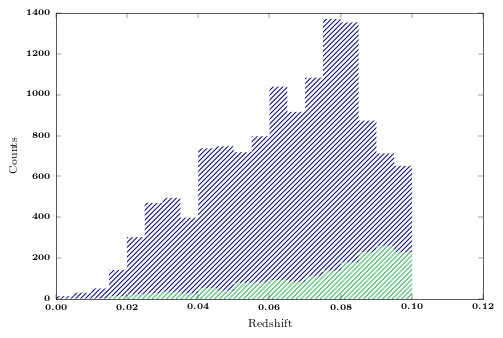

In [11]:
hist(cat["redshift"][c1m], 20, range=(0., 0.1), histtype="step", hatch="/////", lw=0, color=colors[0])
hist(cat["redshift"][c2m], 20, range=(0., 0.1), histtype="step", hatch="/////", lw=0, color=colors[1])

xlabel("Redshift")
ylabel("Counts")

#savefig("redshift.png", bbox_inches="tight")